In [2]:
import numpy as np
import pandas as pd


from PIL import Image
from io import BytesIO
from urllib import request

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.xception import Xception

import matplotlib.pyplot as plt
from IPython.display import display

There are two tasks I need to solve: tackle positions of all dices on image and classify dice type for each position.

I am using two model. First one is custom CNN model for detection position of a dice and the second one is classification model based on pretrained xception model with 'Imagenet' weights.

### Basic Augmentation
According to dataset description dice samples are presented from differen angles.
My experiments shown that almost any model tends to overfit extremely fast.

I am usign additional sheer, zoom and flip augmentation for original images of train dataset provided with ImageDataGenerator

In [3]:
img_size = 128

start_path = '/kaggle/working/dice'
train_path = f"{start_path}/train/"
val_path = f"{start_path}/valid/"

def download_image(url):
    
    with request.urlopen(url) as resp:
        buffer = resp.read()
    stream = BytesIO(buffer)
    img = Image.open(stream)
    return img


def prepare_image(img, target_size):
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize(target_size, Image.NEAREST)
    return img

def preprocess(X, rescale=255):
    
    if rescale:
        X = X*1./rescale
        return X
    return X

def preprocess_xception(X):
    
    X /= 127.5
    X -= 1.
    
    return X

train_gen = ImageDataGenerator(preprocessing_function=preprocess, #rescale=1./255)
    shear_range=0.2,
    zoom_range=0.4,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_dataset = train_gen.flow_from_directory(directory=train_path,
                                              target_size=(img_size, img_size),
#                                               classes=['dicesback'],
                                              class_mode='categorical',
                                              shuffle=True,
                                              batch_size=64)

valid_gen = ImageDataGenerator(preprocessing_function=preprocess) #rescale=1./255)
valid_dataset = valid_gen.flow_from_directory(directory=val_path,
                                              target_size=(img_size, img_size),
#                                               classes=['dicesback'],
                                              class_mode='categorical',
                                              shuffle=True,
                                              batch_size=64)

classes = list(train_dataset.class_indices.keys())

print(train_dataset.class_indices, classes)
print(valid_dataset.class_indices, classes)

Found 15083 images belonging to 7 classes.
Found 2901 images belonging to 7 classes.
{'d10': 0, 'd12': 1, 'd20': 2, 'd4': 3, 'd6': 4, 'd8': 5, 'dicesback': 6} ['d10', 'd12', 'd20', 'd4', 'd6', 'd8', 'dicesback']
{'d10': 0, 'd12': 1, 'd20': 2, 'd4': 3, 'd6': 4, 'd8': 5, 'dicesback': 6} ['d10', 'd12', 'd20', 'd4', 'd6', 'd8', 'dicesback']


## Detection model creation

I am using model with 3 CNN layers with BatchNormalization, Dropout and MaxPooling after each.
As soons as there are six types of dices + background CategoricalCrossentropy will be the loss function.

In fact I want to train a model that simply locates anchor points for dices on image.

In [4]:
def get_model(img_size, learning_rate, droprate=0):
    
    inputs = keras.Input(shape=(img_size, img_size, 3))

    conv_1 = keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same')(inputs)
    conv_1_batched = keras.layers.BatchNormalization()(conv_1)
    conv_1_act = keras.layers.Activation(activation='relu') (conv_1_batched)
    drop_1 = keras.layers.Dropout(droprate)(conv_1_act)

    pooling_1 = keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2,2))(drop_1)
   
    conv_2 = keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same')(pooling_1)
    conv_2_batched = keras.layers.BatchNormalization()(conv_2)
    conv_2_act = keras.layers.Activation(activation='relu') (conv_2_batched)
    drop_2 = keras.layers.Dropout(droprate)(conv_2_act)  
    
    pooling_2 = keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2,2))(drop_2)

    conv_3 = keras.layers.Conv2D(filters=32, kernel_size=(1,1), padding='same')(pooling_2)
    conv_3_batched = keras.layers.BatchNormalization()(conv_3)
    conv_3_act = keras.layers.Activation(activation='relu') (conv_3_batched)
    
    drop_3 = keras.layers.Dropout(droprate)(conv_3_act)

    flatten = keras.layers.Flatten()(drop_3)

    inner_1 = keras.layers.Dense(72, activation='relu')(flatten)

    outputs = keras.layers.Dense(units=7, activation='softmax')(inner_1)

    model = keras.Model(inputs, outputs)   


    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    loss = keras.losses.CategoricalCrossentropy(from_logits=False)

    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
#     display(model.summary())
    
    return model

### Learning rate tuning

On the following pictures we can see that the model tends to overfit after few epochs. Validation loss and accuracy oscillates with learning rates bigger than 0.0001

In [16]:
%%capture outputs_lr
l_rates = [0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001]

history = dict()

for lr in l_rates:
    print(lr)
    detection_model = get_model(img_size, learning_rate=lr, droprate=0)

    history[lr] = detection_model.fit(train_dataset, epochs=10, validation_data=valid_dataset)

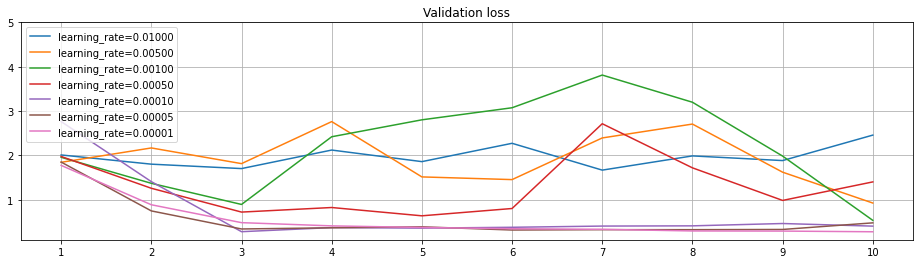

In [29]:
plt.figure(figsize=(16, 4))
for lr in l_rates:
    logs = history[lr].history
    epochs = history[lr].epoch
    plt.plot(np.array(epochs)+1, logs["val_loss"], label="learning_rate=%.5f" %lr)
    plt.grid()
    plt.xticks(np.array(epochs)+1)
    plt.legend(loc='upper left')
    plt.title("Validation loss")
    plt.ylim([0.1, 5])

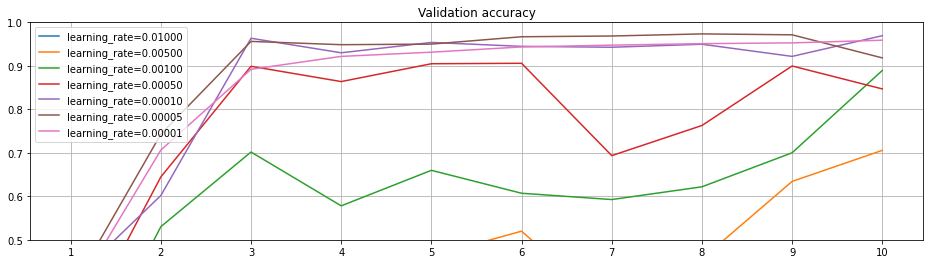

In [33]:
plt.figure(figsize=(16, 4))
for lr in l_rates:
    logs = history[lr].history
    epochs = history[lr].epoch
    plt.plot(np.array(epochs)+1, logs["val_accuracy"], label="learning_rate=%.5f" %lr)
    plt.grid()
    plt.xticks(np.array(epochs)+1)
    plt.legend(loc='upper left')
    plt.title("Validation accuracy")
    plt.ylim([0.5,1])

### Dropout tuning
I've dicided to use signigicant droprate 0.3 after each convolution layer in order to reduce the degree of overfitting.

So accuracy on validation dataset drops from 0.98 to 0.75+

In [6]:
%%capture outputs_dr
best_lr = 0.0001

droprates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

history_dr = dict()

for dr in droprates:
    detection_model = get_model(img_size, learning_rate=best_lr, droprate=dr)

    history_dr[dr] = detection_model.fit(train_dataset, epochs=10, validation_data=valid_dataset)

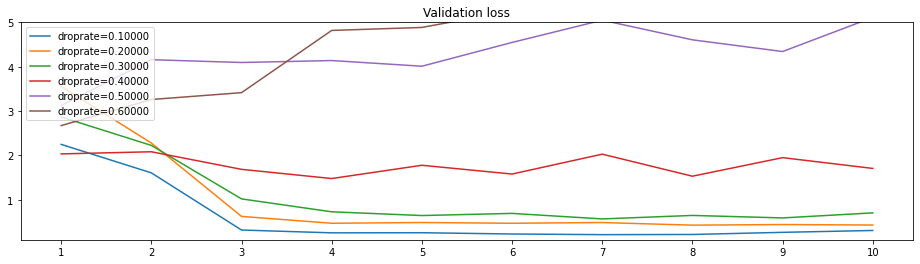

In [7]:
plt.figure(figsize=(16, 4))
for dr in droprates:
    logs = history_dr[dr].history
    epochs = history_dr[dr].epoch
    plt.plot(np.array(epochs)+1, logs["val_loss"], label="droprate=%.5f" %dr)
    plt.xticks(np.array(epochs)+1)
    plt.legend(loc='upper left')
    plt.title("Validation loss")
    plt.ylim([0.1, 5])
plt.grid()
plt.show()

<Figure size 1152x288 with 0 Axes>

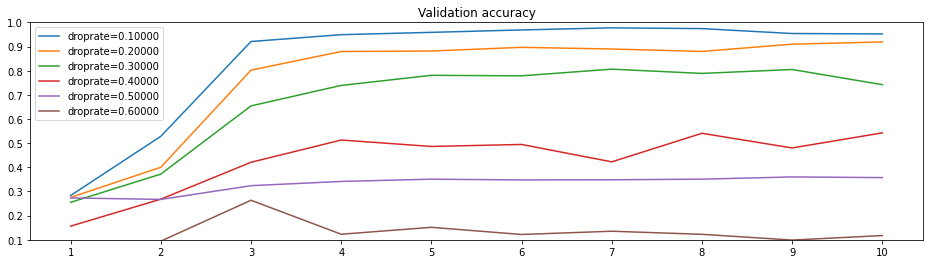

In [8]:
plt.figure(figsize=(16, 4))
for dr in droprates:
    logs = history_dr[dr].history
    epochs = history_dr[dr].epoch
    plt.plot(np.array(epochs)+1, logs["val_accuracy"], label="droprate=%.5f" %dr)
    plt.xticks(np.array(epochs)+1)
    plt.legend(loc='upper left')
    plt.title("Validation accuracy")
    plt.ylim([0.1, 1])
plt.grid()
plt.show

### Number of epochs tuning
Looks like its no need to train model more that 15 epochs as soon as there are no continuous loss dropping on train and validation sets and accuracy simply oscillates.

In [6]:
%%capture output_ep

best_lr = 0.0001
best_dr = 0.3

n_epochs = [10, 15, 20, 25]

history_ep = dict()

for n in n_epochs:
    detection_model = get_model(img_size, learning_rate=best_lr, droprate=best_dr)

    history_ep[n] = detection_model.fit(train_dataset, epochs=n, validation_data=valid_dataset)

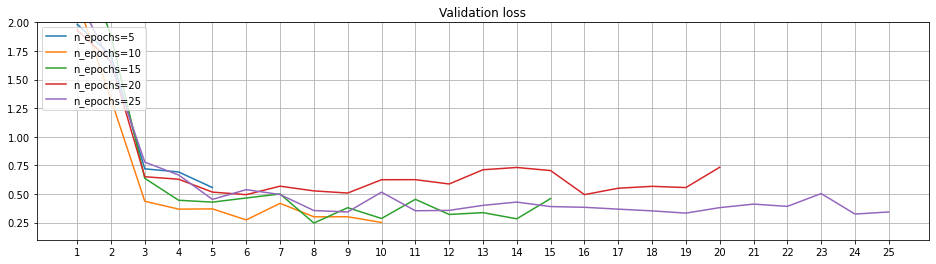

In [10]:
plt.figure(figsize=(16, 4))
for n in n_epochs:
    logs = history_ep[n].history
    epochs = history_ep[n].epoch
    plt.plot(np.array(epochs)+1, logs["val_loss"], label="n_epochs=%.f" %n)
    plt.grid()
    plt.xticks(np.array(epochs)+1)
    plt.legend(loc='upper left')
    plt.title("Validation loss")
    plt.ylim([0.1, 2])

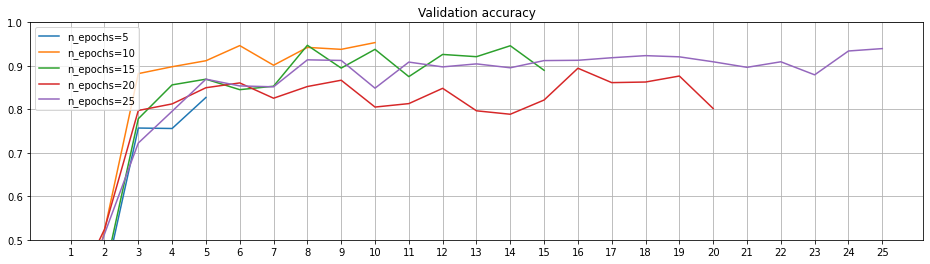

In [15]:
plt.figure(figsize=(16, 4))
for n in n_epochs:
    logs = history_ep[n].history
    epochs = history_ep[n].epoch
    plt.plot(np.array(epochs)+1, logs["val_accuracy"], label="n_epochs=%.f" %n)
    plt.grid()
    plt.xticks(np.array(epochs)+1)
    plt.legend(loc='upper left')
    plt.title("Validation accuracy")
    plt.ylim([0.5, 1])

Finally i decided to use following parametes for vizion model.

In [5]:
best_lr = 0.0001
best_dr = 0.3
selected_n_epochs = 15

detection_model = get_model(img_size, learning_rate=best_lr, droprate=best_dr)

checkpoint = keras.callbacks.ModelCheckpoint("/kaggle/working/dice-detection-model-dr03-{val_accuracy:.3f}.h5",
                                            save_best_only=True, 
                                            monitor="val_accuracy",
                                            mode="max",
)

history_fin = detection_model.fit(train_dataset,
                                  epochs=selected_n_epochs,
                                  validation_data=valid_dataset,
                                 callbacks=[checkpoint])

236/236 [==============================] - 118s 471ms/step - loss: 0.8984 - accuracy: 0.6694 - val_loss: 2.2181 - val_accuracy: 0.2365
Epoch 2/15
236/236 [==============================] - 111s 469ms/step - loss: 0.3609 - accuracy: 0.8846 - val_loss: 2.3028 - val_accuracy: 0.3675
Epoch 3/15
236/236 [==============================] - 111s 472ms/step - loss: 0.2309 - accuracy: 0.9283 - val_loss: 1.0615 - val_accuracy: 0.6350
Epoch 4/15
236/236 [==============================] - 110s 467ms/step - loss: 0.1592 - accuracy: 0.9524 - val_loss: 0.8809 - val_accuracy: 0.7222
Epoch 5/15
236/236 [==============================] - 110s 468ms/step - loss: 0.1233 - accuracy: 0.9626 - val_loss: 0.9409 - val_accuracy: 0.7308
Epoch 6/15
236/236 [==============================] - 110s 467ms/step - loss: 0.0948 - accuracy: 0.9724 - val_loss: 0.8645 - val_accuracy: 0.7484
Epoch 7/15
236/236 [==============================] - 110s 467ms/step - loss: 0.0838 - accuracy: 0.9742 - val_loss: 0.9778 - val_accura

### Dice classification model based on Xception transfer learning

In [4]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_xception,
    shear_range=0.2,
    zoom_range=0.4,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_dataset = train_gen.flow_from_directory(directory=train_path,
                                              target_size=(img_size, img_size),
#                                               classes=['dicesback'],
                                              class_mode='categorical',
                                              shuffle=True,
                                              batch_size=64)

valid_gen = ImageDataGenerator(preprocessing_function=preprocess_xception)
valid_dataset = valid_gen.flow_from_directory(directory=val_path,
                                              target_size=(img_size, img_size),
#                                               classes=['dicesback'],
                                              class_mode='categorical',
                                              shuffle=True,
                                              batch_size=64)

classes = list(train_dataset.class_indices.keys())

print(train_dataset.class_indices, classes)
print(valid_dataset.class_indices, classes)

Found 15083 images belonging to 7 classes.
Found 2901 images belonging to 7 classes.
{'d10': 0, 'd12': 1, 'd20': 2, 'd4': 3, 'd6': 4, 'd8': 5, 'dicesback': 6} ['d10', 'd12', 'd20', 'd4', 'd6', 'd8', 'dicesback']
{'d10': 0, 'd12': 1, 'd20': 2, 'd4': 3, 'd6': 4, 'd8': 5, 'dicesback': 6} ['d10', 'd12', 'd20', 'd4', 'd6', 'd8', 'dicesback']


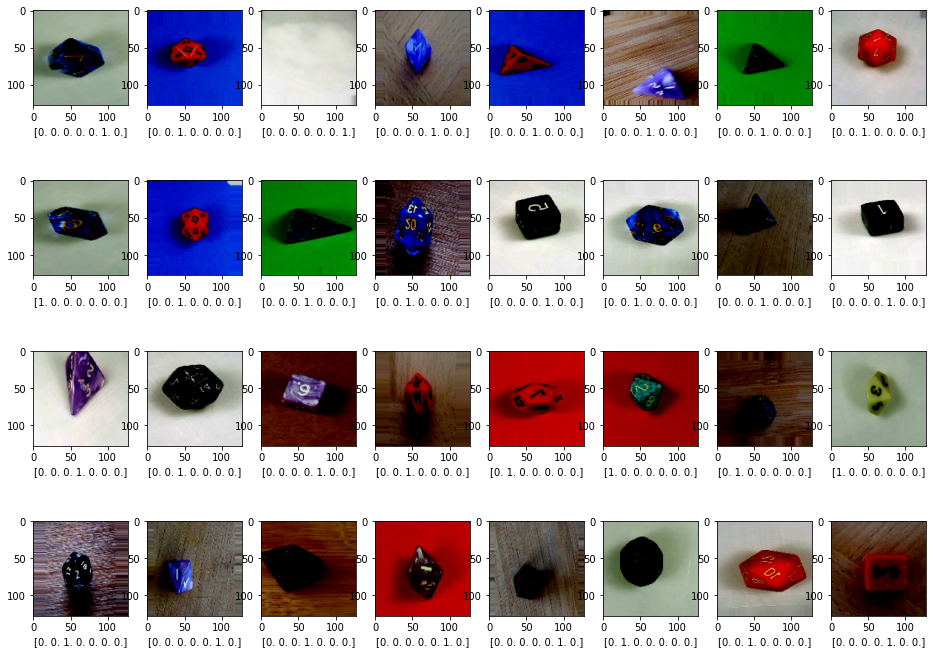

In [6]:
train_imgs = next(train_dataset)

fig, axes = plt.subplots(4, 8, figsize=(16,12))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(train_imgs[0][i])
    ax.set_xlabel(train_imgs[1][i])

In [7]:
def transfer_detection(img_size, inner_size, learning_rate, droprate=0.5):

    base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
    base_model.trainable = False

    inputs = keras.Input(shape=(img_size, img_size, 3))

    base = keras.Model(inputs=base_model.inputs, outputs=base_model.output)(inputs)

    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    drop = keras.layers.Dropout(droprate)(vectors)

    inner = keras.layers.Dense(inner_size, activation='relu')(drop)

    outputs = keras.layers.Dense(7, activation='softmax')(inner)
    
    model = keras.Model(inputs, outputs)
    
        
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    loss = keras.losses.CategoricalCrossentropy(from_logits=False)
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

In [35]:
%%capture outputs_lr
l_rates = [0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001]

history = dict()

for lr in l_rates:
    print(lr)
    classification_model = transfer_detection(img_size=128, inner_size=128, learning_rate=lr, droprate=0)

    history[lr] = classification_model.fit(train_dataset, epochs=10, validation_data=valid_dataset)

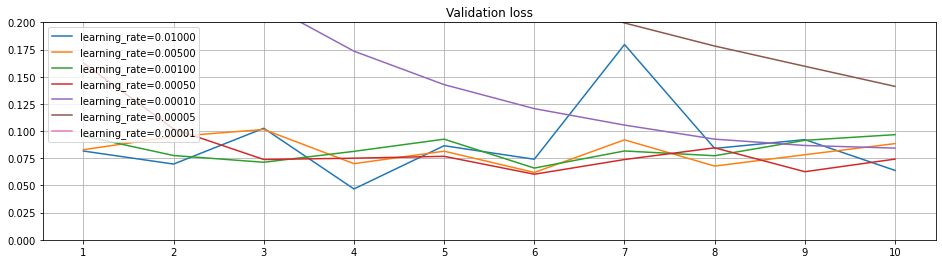

In [36]:
plt.figure(figsize=(16, 4))
for lr in l_rates:
    logs = history[lr].history
    epochs = history[lr].epoch
    plt.plot(np.array(epochs)+1, logs["val_loss"], label="learning_rate=%.5f" %lr)
    plt.grid()
    plt.xticks(np.array(epochs)+1)
    plt.legend(loc='upper left')
    plt.title("Validation loss")
    plt.ylim([0, 0.2])

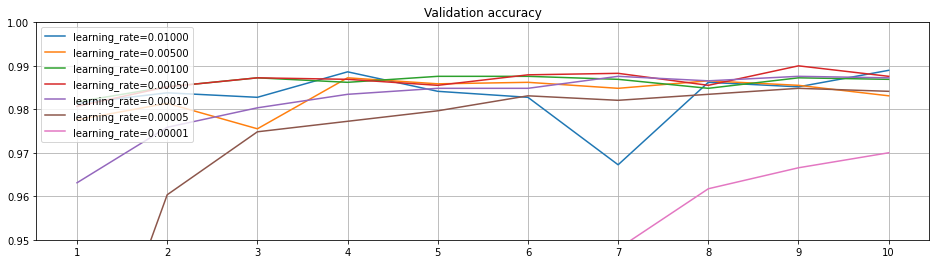

In [43]:
plt.figure(figsize=(16, 4))
for lr in l_rates:
    logs = history[lr].history
    epochs = history[lr].epoch
    plt.plot(np.array(epochs)+1, logs["val_accuracy"], label="learning_rate=%.5f" %lr)
    plt.grid()
    plt.xticks(np.array(epochs)+1)
    plt.legend(loc='upper left')
    plt.title("Validation accuracy")
    plt.ylim([0.95,1])    

In [38]:
%%capture outputs_dr
best_lr = 0.0001

droprates = [0.3, 0.45, 0.6, 0.75, 0.9]

history_dr = dict()

for dr in droprates:
    classification_model = transfer_detection(img_size=128, inner_size=128, learning_rate=best_lr, droprate=dr)

    history_dr[dr] = classification_model.fit(train_dataset, epochs=10, validation_data=valid_dataset)

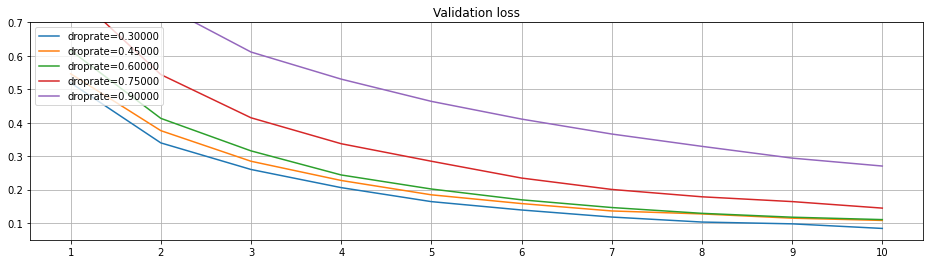

In [42]:
plt.figure(figsize=(16, 4))
for dr in droprates:
    logs = history_dr[dr].history
    epochs = history_dr[dr].epoch
    plt.plot(np.array(epochs)+1, logs["val_loss"], label="droprate=%.5f" %dr)
    plt.grid()
    plt.xticks(np.array(epochs)+1)
    plt.legend(loc='upper left')
    plt.title("Validation loss")
    plt.ylim([0.05, 0.7])

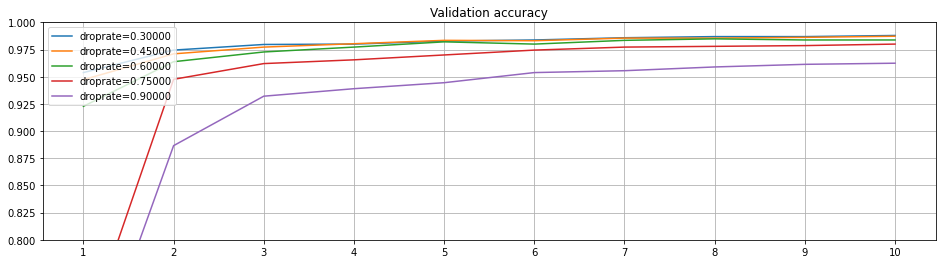

In [41]:
plt.figure(figsize=(16, 4))
for dr in droprates:
    logs = history_dr[dr].history
    epochs = history_dr[dr].epoch
    plt.plot(np.array(epochs)+1, logs["val_accuracy"], label="droprate=%.5f" %dr)
    plt.grid()
    plt.xticks(np.array(epochs)+1)
    plt.legend(loc='upper left')
    plt.title("Validation accuracy")
    plt.ylim([0.8, 1])

In [10]:
%%capture output_ep
best_lr = 0.0001
best_dr = 0.75

n_epochs = [10, 15, 20, 25]

history_ep = dict()

for n in n_epochs:
    classification_model = transfer_detection(img_size=128, inner_size=128, learning_rate=best_lr, droprate=best_dr)

    history_ep[n] = classification_model.fit(train_dataset, epochs=n, validation_data=valid_dataset)


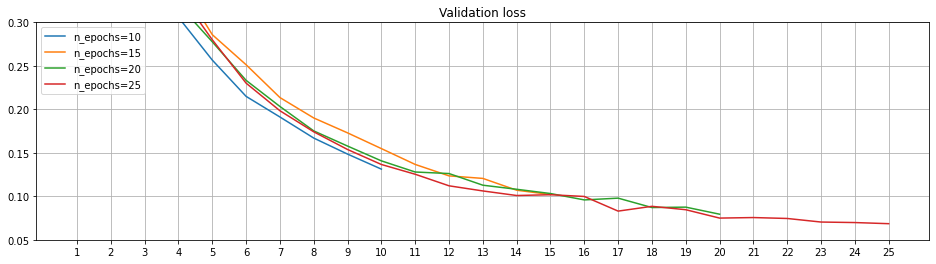

In [17]:
plt.figure(figsize=(16, 4))
for n in n_epochs:
    logs = history_ep[n].history
    epochs = history_ep[n].epoch
    plt.plot(np.array(epochs)+1, logs["val_loss"], label="n_epochs=%.f" %n)
    plt.xticks(np.array(epochs)+1)
    plt.legend(loc='upper left')
    plt.title("Validation loss")
    plt.ylim([0.05, 0.3])
plt.grid()
plt.show()

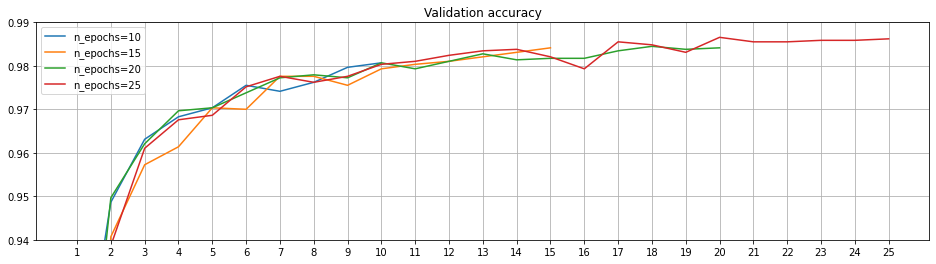

In [21]:
plt.figure(figsize=(16, 4))
for n in n_epochs:
    logs = history_ep[n].history
    epochs = history_ep[n].epoch
    plt.plot(np.array(epochs)+1, logs["val_accuracy"], label="n_epochs=%.f" %n)
    plt.xticks(np.array(epochs)+1)
    plt.legend(loc='upper left')
    plt.title("Validation accuracy")
    plt.ylim([0.94, 0.99])
plt.grid()
plt.show()

In [22]:
best_lr = 0.0001
best_dr = 0.75
selected_n_epochs = 15

classification_model = transfer_detection(img_size=128, inner_size=128, learning_rate=best_lr, droprate=best_dr)

checkpoint = keras.callbacks.ModelCheckpoint("/kaggle/working/xception-classifier-prepr-dr075-{val_accuracy:.3f}.h5",
                                            save_best_only=True, 
                                            monitor="val_accuracy",
                                            mode="max",
)

history_fin = classification_model.fit(train_dataset,
                                  epochs=selected_n_epochs,
                                  validation_data=valid_dataset,
                                 callbacks=[checkpoint])


Epoch 1/15
236/236 [==============================] - 119s 496ms/step - loss: 1.0727 - accuracy: 0.6075 - val_loss: 0.7267 - val_accuracy: 0.8532


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/15
236/236 [==============================] - 115s 489ms/step - loss: 0.5322 - accuracy: 0.8256 - val_loss: 0.5129 - val_accuracy: 0.9514
Epoch 3/15
236/236 [==============================] - 114s 484ms/step - loss: 0.4014 - accuracy: 0.8765 - val_loss: 0.3971 - val_accuracy: 0.9604
Epoch 4/15
236/236 [==============================] - 116s 494ms/step - loss: 0.3408 - accuracy: 0.8916 - val_loss: 0.3249 - val_accuracy: 0.9686
Epoch 5/15
236/236 [==============================] - 117s 496ms/step - loss: 0.2884 - accuracy: 0.9085 - val_loss: 0.2684 - val_accuracy: 0.9724
Epoch 6/15
236/236 [==============================] - 115s 487ms/step - loss: 0.2607 - accuracy: 0.9147 - val_loss: 0.2280 - val_accuracy: 0.9755
Epoch 7/15
236/236 [==============================] - 117s 494ms/step - loss: 0.2377 - accuracy: 0.9235 - val_loss: 0.1952 - val_accuracy: 0.9786
Epoch 8/15
236/236 [==============================] - 116s 490ms/step - loss: 0.2264 - accuracy: 0.9246 - val_loss: 0.1756 -